65536
16


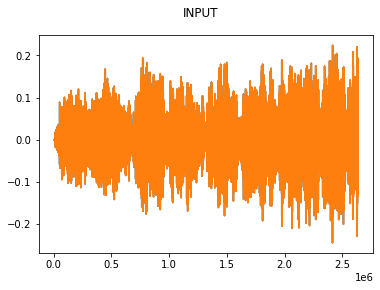

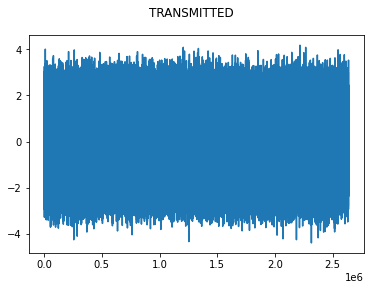

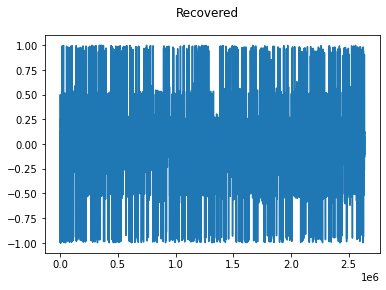

In [4]:
#soundfile needs other dependent packages like CFFI and external system library like libsndfile
import soundfile as sf
from sklearn.preprocessing import normalize
from dec2bin import *
import math as m
import numpy as np
from playsound import playsound
import matplotlib.pyplot as plt

inp = r'aotj1.wav'
out = r'out.wav'
T = 1
Amp = 1 
dt = 0.1
nsamp = int(T/dt)
# change variance
var = 0.8
svar = m.sqrt(var)

data1, fs = sf.read(inp)
#data1 = data1[:20000]
plt.figure(1)
plt.plot(data1)
plt.suptitle('INPUT')
data2 = np.sort(np.unique(data1)) 
lenD1 = len(data1)
lenD2 = len(data2)

minStep = 100 #large number
for i in range(lenD2 - 1):
    if data2[i + 1] - data2[i] < minStep:
        minStep = data2[i + 1] - data2[i]
        
levels = int(2/minStep)
print(levels)
plevels = m.ceil(m.log(levels, 2))
print(plevels)

setH = {}
count = -1
b = 0
for i in range(levels):
    tmp = dec2bin(b).zfill(16)
    tmp2 = ' '.join(map(str, tmp)) 
    setH.update({ tmp2 : count})
    b += 1
    count += minStep

bitseq = []
for i in range(lenD1):
    minimum = -1
    maximum =  1
    for j in range(plevels):
        mid = (minimum + maximum)/2
        if data1[i][0] >= mid:
            bitseq.append(1)
            minimum = mid  
        if data1[i][0] < mid:
            bitseq.append(0)
            maximum = mid    

s1 = []
s1.append(np.zeros(nsamp))
s1.append(Amp*np.ones(nsamp))
s1.append(np.zeros(nsamp))
s1 = np.array(s1)
s1 = np.reshape(s1,[30,])
s1 = np.ndarray.tolist(s1)

s2 = [ -x for x in s1]

h = np.subtract(s1,s2)
# = 2*s1 in our case
a1 = np.dot(s1,h)
a2 = np.dot(s2,h)
threshHold = (a1 + a2)/2
# = 0 in our case

X = []
for i in range(len(bitseq)):
    if bitseq[i] == 1:
        for j in range(nsamp):
            X.append(Amp)
    if bitseq[i] == 0:
        for j in range(nsamp):
            X.append(-Amp)

#plt.figure(1)
#plt.plot(X)
#plt.suptitle('INPUT')
awgn = svar*(np.random.randn(len(bitseq)*nsamp))

Trans = np.add(awgn, X)
plt.figure(2)
plt.plot(awgn[0:lenD1]+data1[:,0])
plt.suptitle('TRANSMITTED')

Recv = np.convolve(h, Trans)
#Zsamp = Recv[::nsamp]
#Zsamp = np.delete(Zsamp, 0)
Zsamp = []
j = 0
for i in range(len(Recv)):
    if j == nsamp - 1:
        Zsamp.append(Recv[i])
        j = 0
    else:
        j += 1

Recov = []
for i in range(len(Zsamp)):
    if Zsamp[i] < threshHold:
        Recov.append(0)
    if Zsamp[i] > threshHold:
        Recov.append(1)
        
Xr = []
i = 0
while i < len(Recov):
    tmp = []
    for j in range(plevels):      
        tmp.append(Recov[i])
        i += 1
    tmp2 = ' '.join(map(str, tmp))
    Xr.append(setH[tmp2])
plt.figure(3)
plt.plot(Xr)
plt.suptitle('Recovered')
sf.write(out, Xr, fs)
#playsound(out)